# Vision Transformer Cover Classification

 # Setup

In [ ]:
!pip install torch torchvision transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#Imports
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from datasets import load_dataset
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive

#Connecting drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Paths
base_path = "/content/drive/MyDrive/FinalYearProject/ClassificationModels/VIT_covers"
output_path = "/content/drive/MyDrive/FinalYearProject/ClassificationModels/Augmented_VIT_covers"

# Image Augmentations

In [ ]:
from torchvision import transforms

#Augmentation pipeline for saving
augmentations_for_saving = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5)
])

#Transformation pipeline for training
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

In [ ]:
#Dataset class to handle loading of images
class RecordCoverDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
#Create a list of paths to all image files in the base directory
image_paths = [os.path.join(base_path, filename)
               for filename in os.listdir(base_path)
               if filename.lower().endswith(('.jpg', '.jpeg', '.png'))]

#Create the output directory for augmented images if it doesn't exist
os.makedirs(output_path, exist_ok=True)

In [ ]:
def augment_and_save(image_path, augmentation, num_augmentations=99):
    """
    Applies a series of augmentations to an image and saves the augmented versions.

    Args:
        image_path (str): The path to the original image file.
        augmentation (callable): A torchvision transform object representing the augmentation pipeline.
        num_augmentations (int, optional): The number of augmented images to generate. Defaults to 99.

    Returns:
        list: A list of file paths to the saved augmented images.
    """

    image = Image.open(image_path)
    base_filename = os.path.basename(image_path)
    image_name, ext = os.path.splitext(base_filename)

    augmented_images = []

    for i in range(num_augmentations):
        #Applying augmentations
        augmented_image = augmentation(image)

        # Save augmented image
        augmented_filename = f"{image_name}_aug_{i+1}{ext}"
        augmented_image_path = os.path.join(output_path, augmented_filename)

        augmented_image.save(augmented_image_path)

        augmented_images.append(augmented_image_path)
    return augmented_images


In [ ]:
# Generate augmentations for each image
all_augmented_images = []
for image_path in image_paths:
    augmented_images = augment_and_save(image_path, augmentations_for_saving, num_augmentations=99)
    all_augmented_images.extend(augmented_images)

print(f"Generated {len(all_augmented_images)} augmented images.")

Generated 0 augmented images.


# Train/Test/Valid Splits

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

In [ ]:
#Initialize lists to store image paths and labels
image_paths = []
labels = []

# Path where the augmented images are stored
augmented_images_dir = '/content/drive/MyDrive/FinalYearProject/ClassificationModels/Augmented_VIT_covers/'

In [ ]:
#Traverse the directory to get image paths and labels
for img_file in os.listdir(augmented_images_dir):
    if img_file.endswith('.jpg'):
        image_path = os.path.join(augmented_images_dir, img_file)
        image_paths.append(image_path)

        #Extract class label
        label = img_file.split('_')[0]  #Get the album name
        labels.append(label)

#Debugging
print(f"Found {len(image_paths)} images.")
print(f"Sample image paths: {image_paths[:5]}")
print(f"Sample labels: {labels[:5]}")

Found 1000 images.
Sample image paths: ['/content/drive/MyDrive/FinalYearProject/ClassificationModels/Augmented_VIT_covers/Whitney_Houston_Whitney_Houston.jpg', '/content/drive/MyDrive/FinalYearProject/ClassificationModels/Augmented_VIT_covers/Midnights_Taylor_Swift.jpg', '/content/drive/MyDrive/FinalYearProject/ClassificationModels/Augmented_VIT_covers/Rumours_Fleetwood_Mac.jpg', '/content/drive/MyDrive/FinalYearProject/ClassificationModels/Augmented_VIT_covers/Wicked_(Original_Broadway_Cast_Recording)_Stephen_Schwartz.jpg', '/content/drive/MyDrive/FinalYearProject/ClassificationModels/Augmented_VIT_covers/Taste_Sabrina_Carpenter.jpg']
Sample labels: ['Whitney', 'Midnights', 'Rumours', 'Wicked', 'Taste']


In [ ]:
import shutil

#Proceed with splitting only if populated
if len(image_paths) > 0:
    #Split the dataset into train, validation, and test sets
    train_images, temp_images, train_labels, temp_labels = train_test_split(
        image_paths, labels, test_size=0.3, random_state=42
    )
    val_images, test_images, val_labels, test_labels = train_test_split(
        temp_images, temp_labels, test_size=0.5, random_state=42
    )

    print(f"Training Set: {len(train_images)} images")
    print(f"Validation Set: {len(val_images)} images")
    print(f"Test Set: {len(test_images)} images")

    #saving the images into their respective folders
    def save_images_to_folder(images, labels, dest_dir):
        for image_path, label in zip(images, labels):
            label_dir = os.path.join(dest_dir, label)
            os.makedirs(label_dir, exist_ok=True)  #Create class folder if it doesn't exist
            shutil.copy(image_path, label_dir)  #Copy the image file to the corresponding folder

    #Save images into the train, validation, and test folders
    save_images_to_folder(train_images, train_labels, train_dir)
    save_images_to_folder(val_images, val_labels, val_dir)
    save_images_to_folder(test_images, test_labels, test_dir)

    print("Images have been saved to the corresponding directories.")
else:
    print("No images found in the directory. Please check the folder structure and paths.")

Training Set: 300 images
Validation Set: 100 images
Test Set: 100 images


KeyboardInterrupt: 

# Vision Transformer

In [ ]:
from torchvision import datasets

In [ ]:
#Define the path for dataset root
base_dir = '/content/drive/MyDrive/FinalYearProject/ClassificationModels/AugmentedDataset'

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   #Resize all images to 224x224
    transforms.RandomHorizontalFlip(),  #Randomly flip images for data augmentation
    transforms.ToTensor(),            #Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet standards
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   #Resize images to 224x224 for validation and testing
    transforms.ToTensor(),            #Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #Normalize
])

In [ ]:
#Loading datasets using ImageFolder
train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(base_dir, 'augmented_val'), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(base_dir, 'augmented_test'), transform=val_test_transforms)

In [ ]:
#Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
num_classes = len(train_dataset.classes)

In [ ]:
from torchvision import models
import torch.nn as nn

#Loading a pre-trained Vision Transformer (ViT) model
vit_model = models.vit_b_16(pretrained=True)

#Modify the final classifier layer to match the number of classes in your dataset
# vit_model.heads = nn.Linear(vit_model.heads.in_features, num_classes) #Original problematic line
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, num_classes)

#Move the model to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model.to(device)

#Print the model to check the architecture
print(vit_model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
import torch.optim as optim

#Loss function: Cross-Entropy Loss for multi-class classification
criterion = nn.CrossEntropyLoss()

#Optimizer: Adam optimizer for training
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)

In [ ]:
from tqdm import tqdm

#Training loop
num_epochs = 10  #Set the number of epochs for training

for epoch in range(num_epochs):
    vit_model.train()  #Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    #Loop through the training data
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)

        #Zero the parameter gradients
        optimizer.zero_grad()

        #Forward pass
        outputs = vit_model(inputs)
        loss = criterion(outputs, labels)

        #Backward pass and optimization
        loss.backward()
        optimizer.step()

        #Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_preds / total_preds * 100

    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%")

Epoch 1/10: 100%|██████████| 44/44 [04:02<00:00,  5.51s/it]


Train Loss: 0.0200, Train Accuracy: 99.57%


Epoch 2/10: 100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Train Loss: 0.0004, Train Accuracy: 100.00%


Epoch 3/10: 100%|██████████| 44/44 [00:27<00:00,  1.60it/s]


Train Loss: 0.0002, Train Accuracy: 100.00%


Epoch 4/10: 100%|██████████| 44/44 [00:27<00:00,  1.58it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch 5/10: 100%|██████████| 44/44 [00:28<00:00,  1.57it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch 6/10: 100%|██████████| 44/44 [00:28<00:00,  1.54it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch 7/10: 100%|██████████| 44/44 [00:29<00:00,  1.52it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch 8/10: 100%|██████████| 44/44 [00:29<00:00,  1.51it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch 9/10: 100%|██████████| 44/44 [00:28<00:00,  1.52it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Epoch 10/10: 100%|██████████| 44/44 [00:29<00:00,  1.51it/s]

Train Loss: 0.0001, Train Accuracy: 100.00%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Evaluation on the test set
vit_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vit_model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

Evaluating: 100%|██████████| 10/10 [00:57<00:00,  5.77s/it]


In [ ]:
#Generating classification report
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

                 precision    recall  f1-score   support

MidnightsCovers       1.00      0.60      0.75        30
  RumoursCovers       0.91      1.00      0.95        30
    TasteCovers       0.59      0.73      0.66        30
  WhitneyCovers       0.95      0.67      0.78        30
   WickedCovers       0.49      0.67      0.56        30

       accuracy                           0.73       150
      macro avg       0.79      0.73      0.74       150
   weighted avg       0.79      0.73      0.74       150



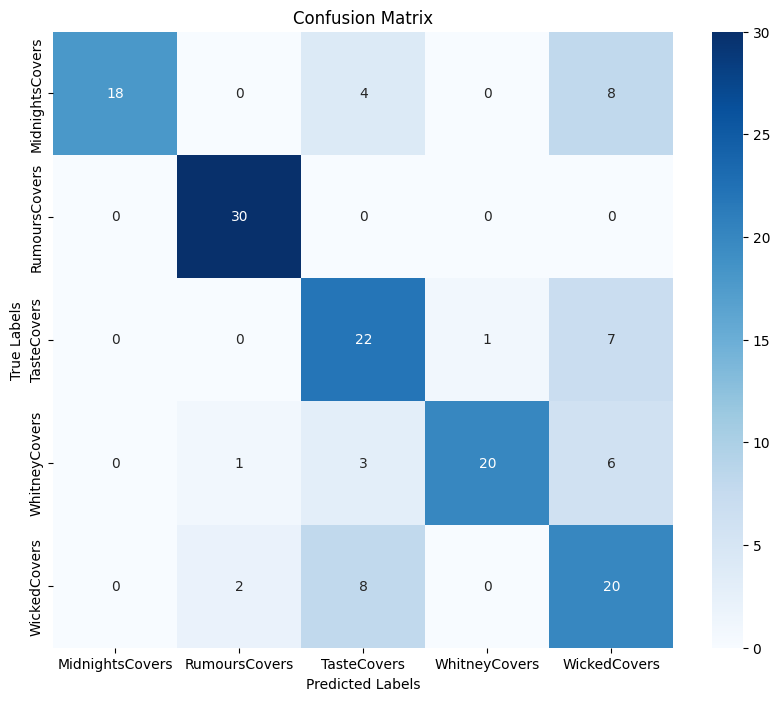

In [ ]:
#Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)

#Visualising the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()